# <a id='vverh'>Домашнее задание №5</a>

1) Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).<br>
[задание №1](#10) <br>
<br>
2) Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.<br>
[задание №2](#11) <br>

3) * Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.<br>

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
classification_data, classification_labels = make_classification(n_samples=1000,n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=17)

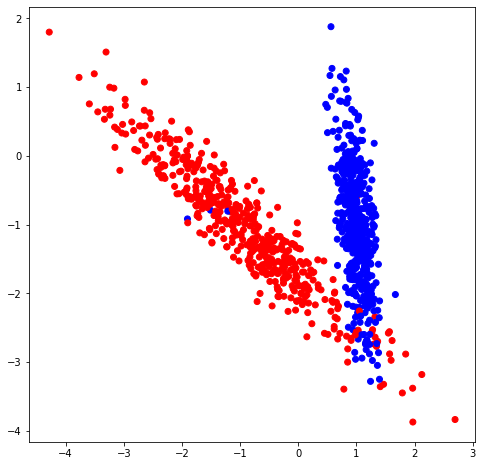

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.round(np.sqrt(len_sample)))
    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction   

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет прироста

def gain(left_labels, right_labels, root_criterion, criterion):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
#     min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini, gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [13]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [14]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
#     print(node.index, obj[node.index])
    if obj[node.index] <= node.t:
        
        return classify_object(obj, node.true_branch)
    else:
        
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [17]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [18]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [19]:
%%time
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

Wall time: 197 ms


In [20]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [21]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [22]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 97.000
Точность случайного леса из 1 деревьев на тестовой выборке: 95.667


In [23]:
%%time
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

Wall time: 636 ms


In [24]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [25]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [26]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 99.286
Точность случайного леса из 3 деревьев на тестовой выборке: 98.667


In [27]:
%%time
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

Wall time: 2.28 s


In [28]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [29]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [30]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 99.857
Точность случайного леса из 10 деревьев на тестовой выборке: 98.667


In [31]:
%%time
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

Wall time: 12.3 s


In [32]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [33]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [34]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 99.000


In [35]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.01, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data, my_forest):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    temp = tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])
#     print(temp)
    mesh_predictions = np.array(temp).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

<a id='10'>Задание 1</a> <br>
1) Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). <br>
[Мне наверх](#vverh)

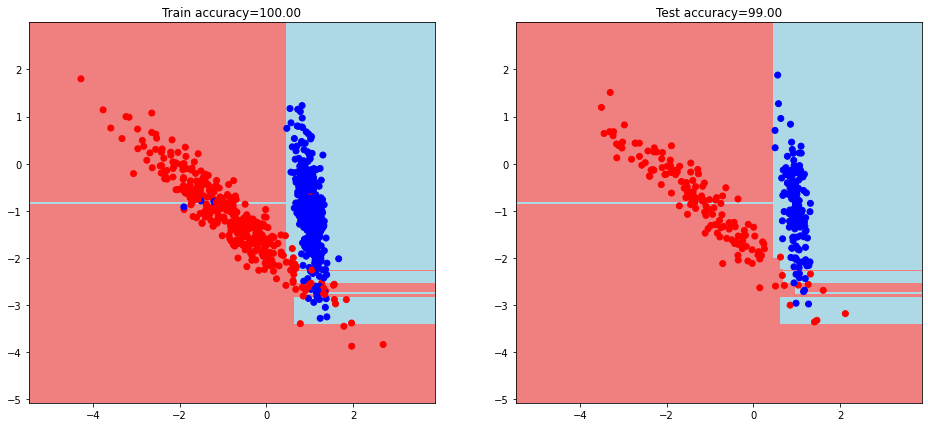

In [36]:
visualize(train_data, test_data, my_forest_1)


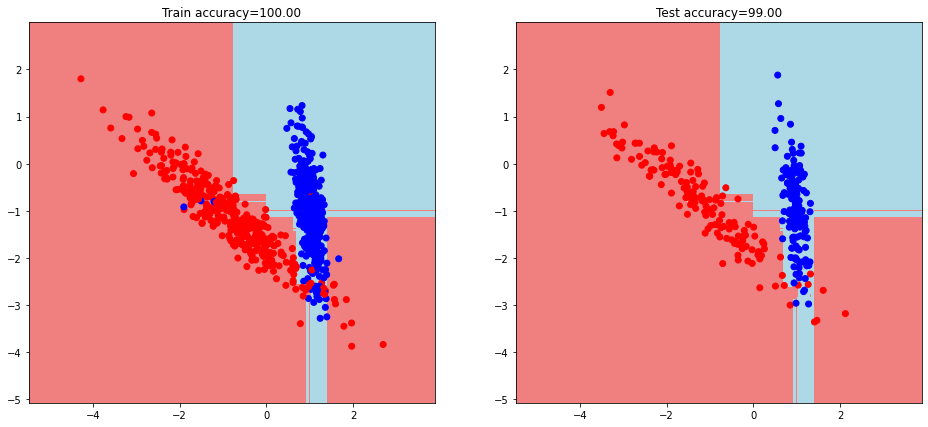

In [37]:
visualize(train_data, test_data, my_forest_3)


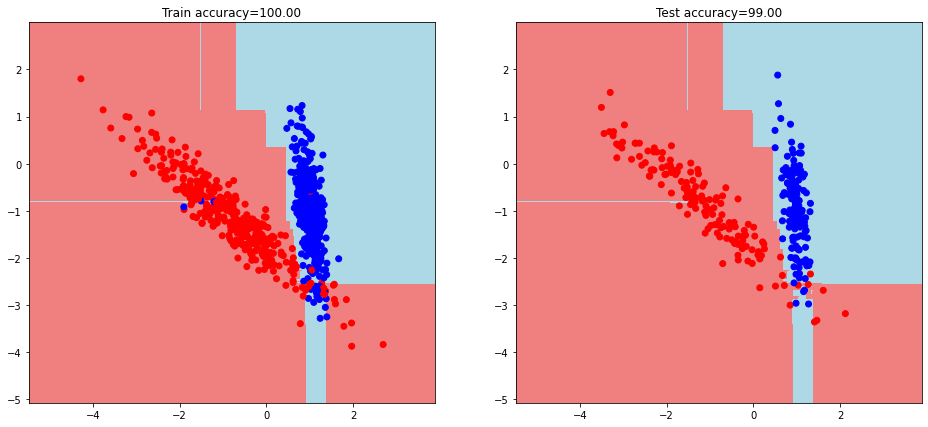

In [38]:
visualize(train_data, test_data, my_forest_10)


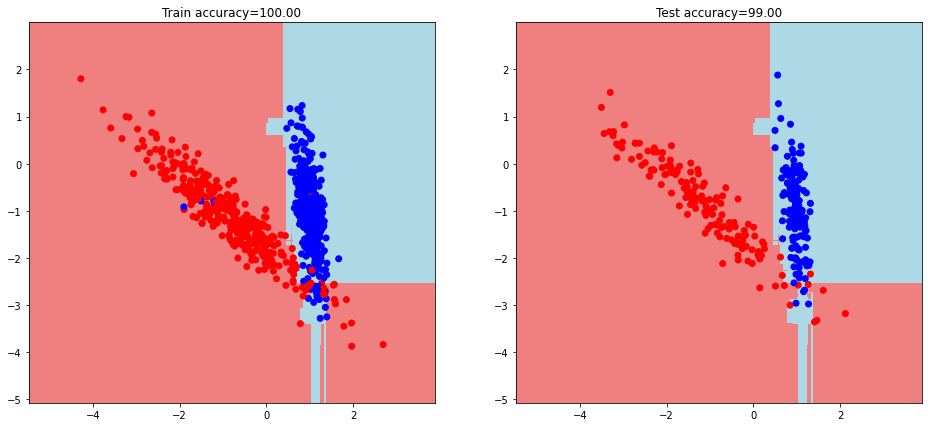

In [39]:
visualize(train_data, test_data, my_forest_50)

[Мне наверх](#vverh)

<a id='11'>Задание 2</a> <br>
2) Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.<br>

Ответ: <br>
сперва дерево пыталось подстроиться под все синие точки, в том числе и те, которые выглядят как выброс среди красных точек. <br>
Когда дело дошло до 3 деревьев, то модели стало понятно, что потенциально данные могут идти дальше вниз и появился маршрут для синих, если бы они вдруг туда попали. <br>
10 деревьев продолжили тенденцию леса из трёх деревьев, но попытались научиться ещё и точкам в красном облаке, что не есть хорошо (совсем малость переобучения) <br>
лес из 50 деревьев стал переобучаться: он потенциально сокращает количество правильных ответов для синих, если бы данные продолжили двигаться в ту же сторону(или идти из той стороны). Но в качестве бонуса он(лес) не посчитал выбросы в красных данных
